In [ ]:
import pandas as pd
import yfinance as y
import numpy as np


data = y.download("TSLA", start="2022-01-01", end="2024-01-01", interval="1d", auto_adjust=True)

data.columns = data.columns.get_level_values(0)

print(data.head())

print(data.columns)

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Date                                                                 
2022-01-03  399.926666  400.356659  378.679993  382.583344  103931400
2022-01-04  383.196655  402.666656  374.350006  396.516663  100248300
2022-01-05  362.706665  390.113342  360.336670  382.216675   80119800
2022-01-06  354.899994  362.666656  340.166656  359.000000   90336600
2022-01-07  342.320007  360.309998  336.666656  360.123322   84164700
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


No need to append DataFrame to csv file, will work on it locally

Calculating Simple Returns, Log Returns, Simple Moving Average for 20- and 50 days

In [59]:
# Returns
data['Simple_Returns'] = data['Close'].pct_change()
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# SMA
data['SMA_20'] = data['Close'].rolling(20).mean()
data['SMA_50'] = data['Close'].rolling(50).mean()

# New feature before definining the signal
data['Price_SMA_ratio'] = data['Close'] / data['SMA_20']

# Volatility
data['Volatility_20'] = data['Close'].pct_change().rolling(20).std()

data['SMA_diff'] = data['SMA_20'] - data['SMA_50']
data['Return_1'] = data['Close'].pct_change(1)
data['Return_5'] = data['Close'].pct_change(5)
data['SMA_Crossover'] = (data['SMA_20'] > data['SMA_50']).astype(int)


print(data.head())

Price            Close        High         Low        Open     Volume  \
Date                                                                    
2022-01-03  399.926666  400.356659  378.679993  382.583344  103931400   
2022-01-04  383.196655  402.666656  374.350006  396.516663  100248300   
2022-01-05  362.706665  390.113342  360.336670  382.216675   80119800   
2022-01-06  354.899994  362.666656  340.166656  359.000000   90336600   
2022-01-07  342.320007  360.309998  336.666656  360.123322   84164700   

Price       Simple_Returns  Log_Returns  SMA_20  SMA_50  Price_SMA_ratio  \
Date                                                                       
2022-01-03             NaN          NaN     NaN     NaN              NaN   
2022-01-04       -0.041833    -0.042733     NaN     NaN              NaN   
2022-01-05       -0.053471    -0.054954     NaN     NaN              NaN   
2022-01-06       -0.021523    -0.021758     NaN     NaN              NaN   
2022-01-07       -0.035447    -0

See how these variables come out in a plot

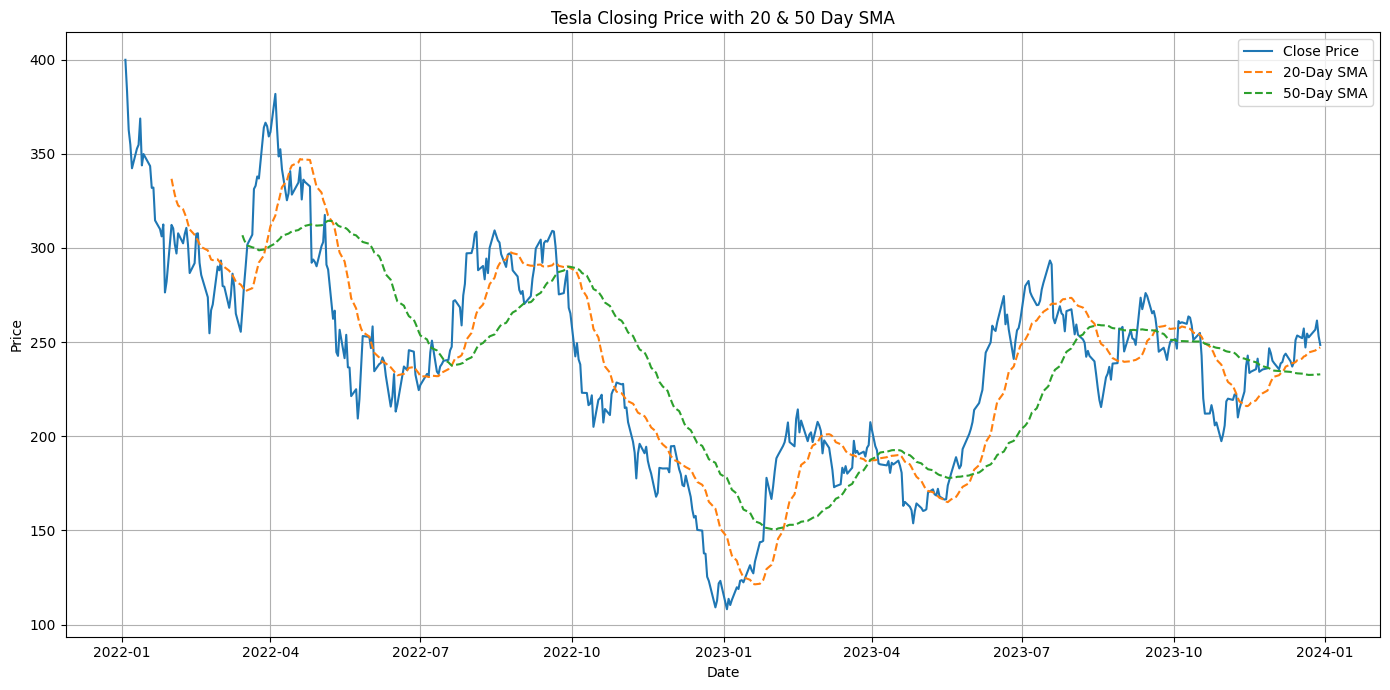

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_20'], label='20-Day SMA', linestyle='--')
plt.plot(data['SMA_50'], label='50-Day SMA', linestyle='--')
plt.title('Tesla Closing Price with 20 & 50 Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Implementing buy signals according to SMA analysis where 1 signals buy and -1 signals sell

In [61]:
# Initializing signals

data['Signal'] = 0
data.loc[
    (data['SMA_20'] > data['SMA_50']) &
    (data['Price_SMA_ratio'] > 1.01) &
    (data['Volatility_20'] < 0.03) &
    (data['Return_1'] > 0),
    'Signal'
] = 1

data.loc[
    (data['SMA_20'] < data['SMA_50']) &
    (data['Price_SMA_ratio'] < 0.99) &
    (data['Volatility_20'] > 0.03) &
    (data['Return_1'] < 0),
    'Signal'
] = -1

data['Position'] = data['Signal'].diff()
data['Strategy_Return'] = data['Signal'].shift(1) * data['Simple_Returns']


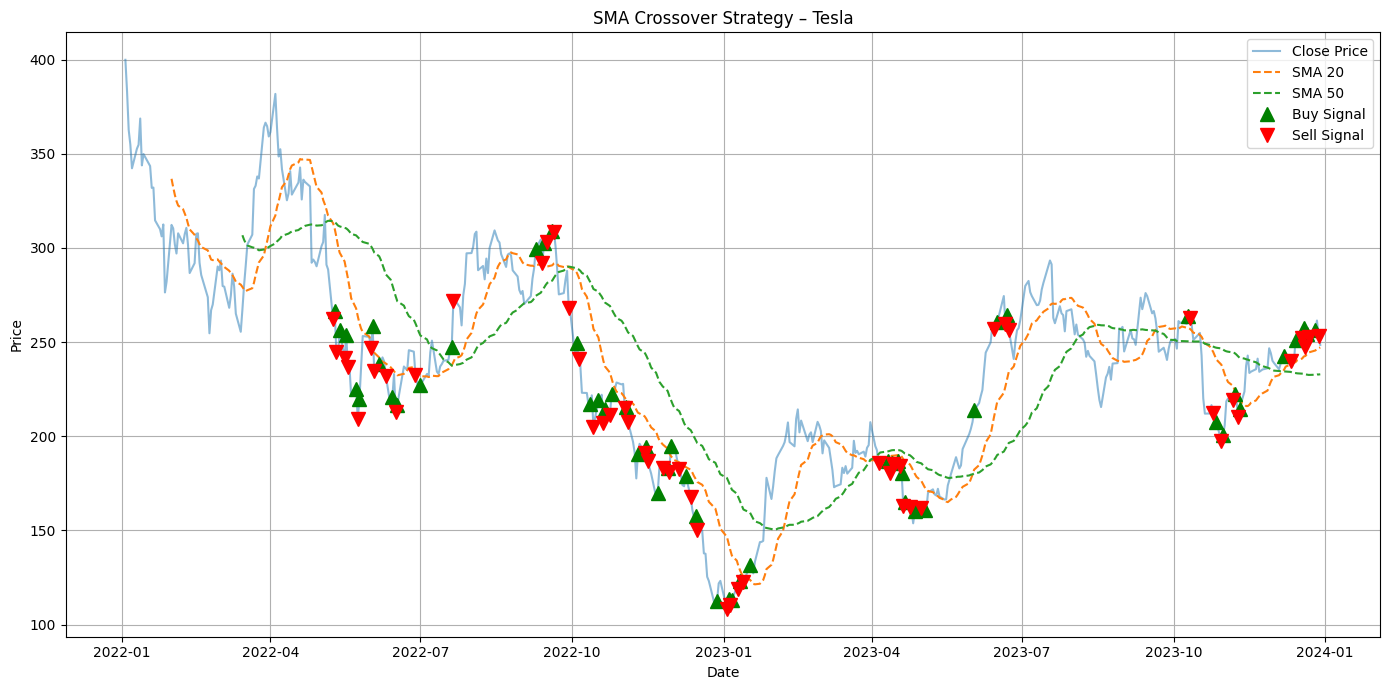

In [62]:
# Visualizing the signals using plots

plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(data['SMA_50'], label='SMA 50', linestyle='--')

# Buy signal
plt.plot(data[data['Position'] == 1].index, 
         data['Close'][data['Position'] == 1], 
         '^', markersize=10, color='green', label='Buy Signal')

# Sell signal
plt.plot(data[data['Position'] == -1].index, 
         data['Close'][data['Position'] == -1], 
         'v', markersize=10, color='red', label='Sell Signal')

plt.title('SMA Crossover Strategy – Tesla')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Cumulative Returns'}, xlabel='Date'>

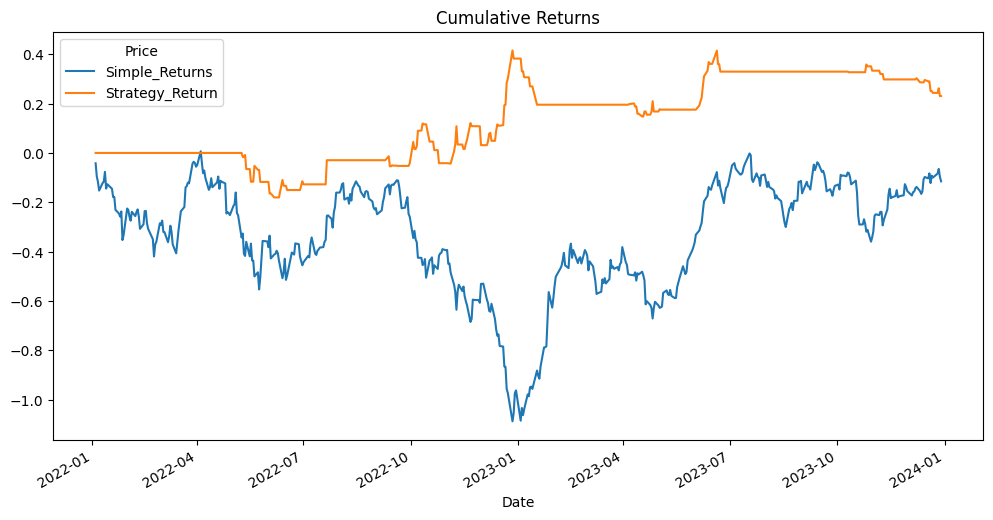

In [63]:
# Strategical returns

data['Strategy_Return'] = data['Simple_Returns'] * data['Signal'].shift(1)
data[['Simple_Returns', 'Strategy_Return']].cumsum().plot(figsize=(12,6), title='Cumulative Returns')


SMA-Crossover does not beat the buy and hold method. Try additional features to boost it

In [64]:
data['SMA_diff'] = data['SMA_20'] - data['SMA_50']
data['Return_1'] = data['Close'].pct_change(1)
data['Return_5'] = data['Close'].pct_change(5)
data['SMA_Crossover'] = (data['SMA_20'] > data['SMA_50']).astype(int)

Plot with additional features

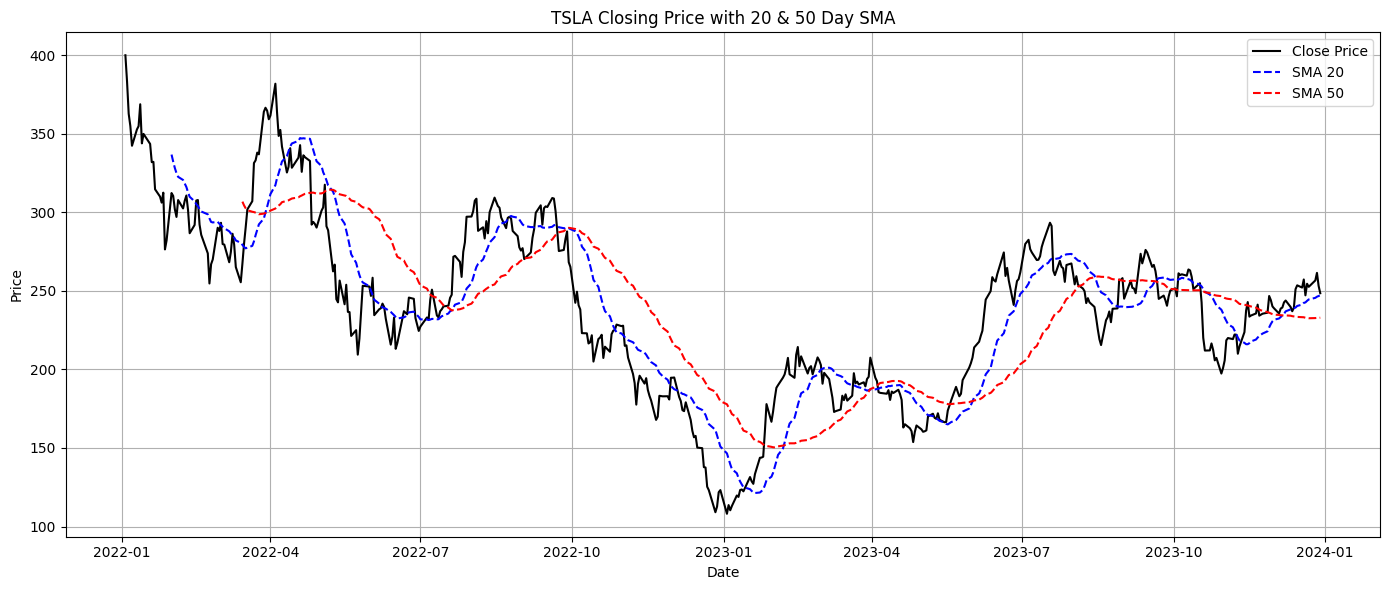

In [65]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='black')
plt.plot(data.index, data['SMA_20'], label='SMA 20', color='blue', linestyle='--')
plt.plot(data.index, data['SMA_50'], label='SMA 50', color='red', linestyle='--')
plt.title('TSLA Closing Price with 20 & 50 Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Implementing a Rule-based strategy and calculating cumulative strategy vs. market return

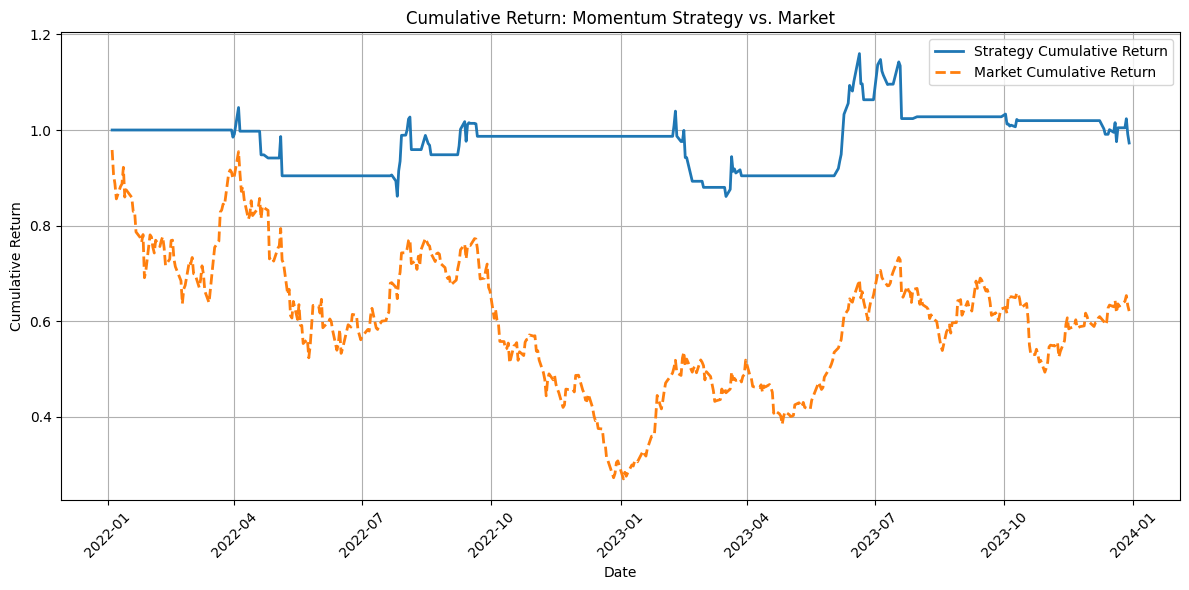

In [66]:
# Strategy Rule: Buy if 5-day return is strong and trend is strong
data['Position'] = ((data['Return_5'] > 0.015) & (data['SMA_diff'] > 1.0)).astype(int)

# Shift position to avoid lookahead bias (act on signal the next day)
data['Strategy_Return'] = data['Position'].shift(1) * data['Return_1']

# Market return (buy and hold strategy)
data['Market_Return'] = data['Return_1']

# Compute cumulative returns
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod()
data['Cumulative_Market'] = (1 + data['Market_Return']).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative_Strategy'], label='Strategy Cumulative Return', linewidth=2)
plt.plot(data.index, data['Cumulative_Market'], label='Market Cumulative Return', linestyle='--', linewidth=2)
plt.title('Cumulative Return: Momentum Strategy vs. Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Annualized returns from this Rule-based method

In [68]:
# Strategy Metrics
annualized_return_strategy = data['Strategy_Return'].mean() * 252
annualized_volatility_strategy = data['Strategy_Return'].std() * np.sqrt(252)
sharpe_ratio_strategy = annualized_return_strategy / annualized_volatility_strategy
rolling_max_strategy = data['Cumulative_Strategy'].cummax()
max_drawdown_strategy = (data['Cumulative_Strategy'] / rolling_max_strategy - 1).min()

# Market Metrics
annualized_return_market = data['Market_Return'].mean() * 252
annualized_volatility_market = data['Market_Return'].std() * np.sqrt(252)
sharpe_ratio_market = annualized_return_market / annualized_volatility_market
rolling_max_market = data['Cumulative_Market'].cummax()
max_drawdown_market = (data['Cumulative_Market'] / rolling_max_market - 1).min()

# Print all results
print("Strategy Performance Metrics:")
print(f"Annualized Return: {annualized_return_strategy:.2%}")
print(f"Annualized Volatility: {annualized_volatility_strategy:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_strategy:.2f}")
print(f"Max Drawdown: {max_drawdown_strategy:.2%}\n")

print("Market Performance Metrics:")
print(f"Annualized Return: {annualized_return_market:.2%}")
print(f"Annualized Volatility: {annualized_volatility_market:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_market:.2f}")
print(f"Max Drawdown: {max_drawdown_market:.2%}")

Strategy Performance Metrics:
Annualized Return: 0.98%
Annualized Volatility: 21.71%
Sharpe Ratio: 0.05
Max Drawdown: -17.78%

Market Performance Metrics:
Annualized Return: -5.80%
Annualized Volatility: 60.17%
Sharpe Ratio: -0.10
Max Drawdown: -71.79%


Trade Analysis following this model

In [69]:
data = data.dropna(subset=['Strategy_Return'])

# identify where signal changes from 0 to 1 or -1
data['Trade_Entry'] = data['Signal'].diff().fillna(0) != 0

data["Trade_ID"] = data['Trade_Entry'].cumsum()

strategy_trades = data[data['Signal'] != 0].groupby('Trade_ID')['Strategy_Return'].sum()

# metrics
num_trades = strategy_trades.count()
wins = (strategy_trades > 0).sum()
losses = (strategy_trades < 0).sum()
win_rate = wins / num_trades if num_trades else 0
avg_return = strategy_trades.mean()
max_gain = strategy_trades.max()
max_loss = strategy_trades.min()
sharpe_ratio = (
    strategy_trades.mean() / strategy_trades.std() * np.sqrt(252)
    if strategy_trades.std() != 0 else np.nan
)

In [70]:
# Display results
print(f"Number of Trades: {num_trades}")
print(f"Winning Trades: {wins}")
print(f"Losing Trades: {losses}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Average Return per Trade: {avg_return:.4f}")
print(f"Max Gain: {max_gain:.4f}")
print(f"Max Loss: {max_loss:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Number of Trades: 52
Winning Trades: 9
Losing Trades: 0
Win Rate: 17.31%
Average Return per Trade: 0.0087
Max Gain: 0.1929
Max Loss: 0.0000
Sharpe Ratio: 4.64
